# Modeling of COVID-19 Data

### Group 2: Ian Metz, Sanjya Amaratunga, Nermin Kremic, Stephanie Reynolds

This notebook uses the linear regression model ElasticNet to predict total Covid-19 cases per million in April for four countries.

### Part 4 - Apply the linear regression model ElasticNet to predict total Covid-19 cases per million in April for our target countries

### Data Source
URL: https://github.com/owid/covid-19-data/tree/master/public/data
Data is maintained by Our World in Data and combines multiple data sources including John Hopkins, CDC, ECDC, WHO, and Britain's NHS

### Import needed Libraries

In [1]:
##Import needed Libraries
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from pandas.tseries.offsets import DateOffset

### Import and Scrub Data from Github

In [2]:
#Define needed columns from the dataset used throughout the notebook
neededColumns = ["date","location","total_cases_per_million","new_cases_per_million","total_deaths_per_million","human_development_index","median_age","population"]

#Import CSV
covid19Dataframe = pd.read_csv("https://raw.githubusercontent.com/WhipSnake23/Python-Class-Project/main/Data/owid-covid-data.csv")
#Filter data to the 4 countries needed (Canada, India, USA, Italy)
covid19Dataframe = covid19Dataframe[covid19Dataframe.iso_code.str.contains("CAN")| (covid19Dataframe.iso_code.str.contains("IND")) | (covid19Dataframe.iso_code.str.contains("ITA")) | (covid19Dataframe.iso_code.str.contains("USA"))]
#Filter dataframe to only the needed columns
covid19Dataframe = covid19Dataframe[neededColumns]
#Drop rows with empty values in columns. This is typically dates from the start of Covid-19 in 2020
covid19Dataframe.dropna(subset=["new_cases_per_million"],inplace=True)
covid19Dataframe.dropna(subset=["total_deaths_per_million"],inplace=True)
#Convert date column to a date for use in prediction
covid19Dataframe["date"] = pd.to_datetime(covid19Dataframe["date"])
#Reset data frame index Index
covid19Dataframe.reset_index(drop=True, inplace=True)

#Import March data for the 4 countries to be used when predicting April
marchCovidData = pd.read_csv("https://raw.githubusercontent.com/WhipSnake23/Python-Class-Project/main/Data/Covid-IND_CAN-USA_ITA-March.csv")
#Filter down to needed Columns
marchCovidData = marchCovidData[neededColumns]
#Remove any blank values
marchCovidData.dropna(subset=["new_cases_per_million"],inplace=True)
marchCovidData.dropna(subset=["total_deaths_per_million"],inplace=True)
#Convert date column to a date for use in prediction
marchCovidData["date"] = pd.to_datetime(marchCovidData["date"])
#Reset Index
marchCovidData.reset_index(drop=True, inplace=True)


### Define Notebook Functions

In [3]:
#Prints the Scores from the run of the algorithm against the data
def printMetrics(f_test, f_predictions):
    print(f"Score: {explained_variance_score(f_test, f_predictions):.2f}")
    print(f"MAE: {mean_absolute_error(f_test, f_predictions):.2f}")
    print(f"RMSE: {math.sqrt(mean_squared_error(f_test, f_predictions)):.2f}")
    print(f"r2: {r2_score(f_test, f_predictions):.2f}")

In [4]:
#Define target column
targetColumn = "total_cases_per_million"

### Train and Define the Model
##### Description:
The below features provided the best model. Both new cases per million and total deaths per million had the most impact on the model. Additionally, adding more columns actually causes the model to get worse.

Features Uses
- new_cases_per_million
- total_deaths_per_million
- human_development_index*
- median_age
- population

*The human is defined as a composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506

In [5]:
#Define feature columns
featureColumns = ["new_cases_per_million","total_deaths_per_million","human_development_index","median_age","population"]

#set Target and Feature data
features=covid19Dataframe[featureColumns]
target=covid19Dataframe[targetColumn]
#Prep data for model run
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1)
#Define the model and any options. The model was performing better using 10,000 iterations rather then the default 1000
model = ElasticNet(random_state=1,max_iter=10000)
#Fit the model to the data
model.fit(x_train, y_train)
predictions = model.predict(x_test)
#Score the model off the data
printMetrics(y_test, predictions)

Score: 0.92
MAE: 3185.80
RMSE: 4726.74
r2: 0.92


### Predict total cases per million for April
##### Description:
Using data from the model trained about and data from the month of March where total_deaths_per_million and new_cases_per_million features are increased and decreased by 15%.

In [6]:
#Copy the data frame into a separate one for modification
aprilCovidDataIncrease = marchCovidData.copy()

aprilCovidDataIncrease["total_deaths_per_million"] = (aprilCovidDataIncrease["total_deaths_per_million"] * .15) + aprilCovidDataIncrease["total_deaths_per_million"]
aprilCovidDataIncrease["new_cases_per_million"] = (aprilCovidDataIncrease["new_cases_per_million"] * .15) + aprilCovidDataIncrease["new_cases_per_million"]
aprilCovidDataIncrease["date"] = aprilCovidDataIncrease["date"] + DateOffset(months=1)
aprilCovidDataIncrease.insert(6,"model","increase",True)

#Use a lamdba function to run the predict model on each rows data
aprilCovidDataIncrease["predictions"] = aprilCovidDataIncrease[featureColumns].apply(
    lambda s: model.predict(s.values[None])[0], axis=1
)

#Copy the data frame into a separate one for modification
aprilCovidDataDecrease = marchCovidData.copy()
aprilCovidDataDecrease["total_deaths_per_million"] = aprilCovidDataDecrease["total_deaths_per_million"] - (aprilCovidDataDecrease["total_deaths_per_million"] * .15)
aprilCovidDataDecrease["new_cases_per_million"] = aprilCovidDataDecrease["new_cases_per_million"] - (aprilCovidDataDecrease["new_cases_per_million"] * .15)
aprilCovidDataDecrease["date"] = aprilCovidDataDecrease["date"] + DateOffset(months=1)
aprilCovidDataDecrease.insert(6,"model","decrease",True)
#Use a lamdba function to run the predict model on each rows data
aprilCovidDataDecrease["predictions"] = aprilCovidDataDecrease[featureColumns].apply(
    lambda s: model.predict(s.values[None])[0], axis=1
)

#Combine the data frames for use in Seaborn
aprilCovidDataPredictions = pd.concat([aprilCovidDataIncrease, aprilCovidDataDecrease])
#Rename Columns for Charting
aprilCovidDataPredictions = aprilCovidDataPredictions.rename(columns={"date": "Date", "predictions": "Predicted Cases Per Million","location": "Country","model": "Model"})
#combinedDataframe

### Plot the predictions
##### Data Analysis:
- For both the US and Italy a 15% increase in total_deaths_per_million and new_cases_per_million would cause a significant increase in total cases per million.
- If there is a 15% decrease in total_deaths_per_million and new_cases_per_million for the US and Italy then total cases per million would only increase slightly and remain far flatter.
- Canada would see an increase but nowhere near as large as the US or Italy. Additionally, Canada remains flatter regardless of an increase or decrease in total_deaths_per_million and new_cases_per_million.
- India's total cases per million prediction draws into question the quality of their data. Given how vastly different India's trend and lines appear from the other three countries it seems there data is not as accurate.

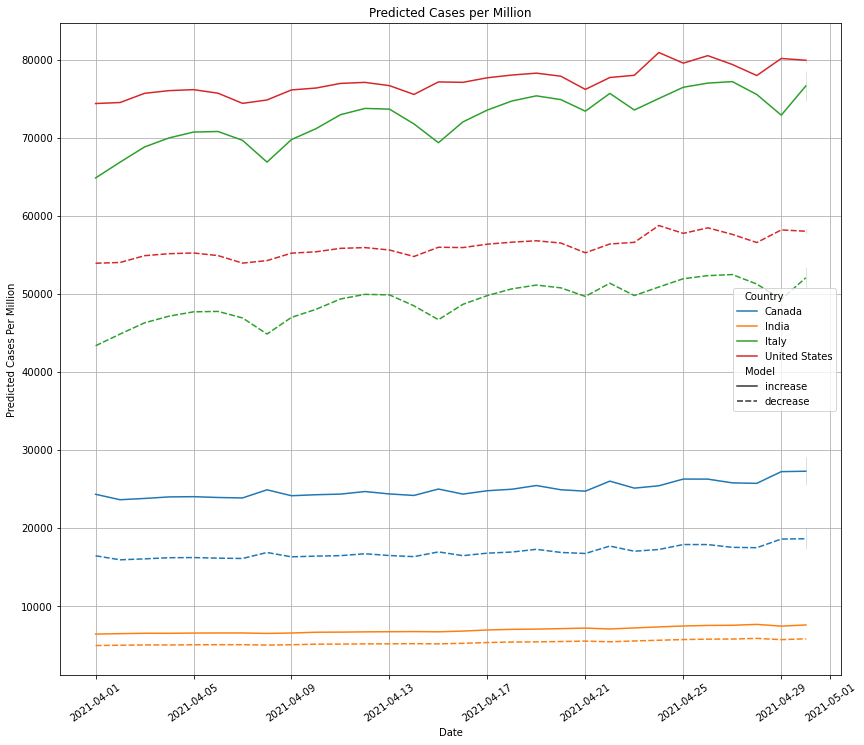

In [7]:
# #Sets figure size
plt.figure(figsize=(14,12))
#rotates the x axis
plt.xticks(rotation=35)
#ensures grid lines are on the image
plt.grid(b=True,which='major')
#Builds the Chart
aprilCovidPrediction = sns.lineplot(data=aprilCovidDataPredictions, x="Date", y="Predicted Cases Per Million", hue="Country",style="Model").set_title("Predicted Cases per Million")
aprilCovidPrediction.figure.canvas.draw()
